# Just for testing random things

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
import os
import sys
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_first_elements
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.common.testing.shared import CONFIG
from explanations.data_enhancing import enhance_data


2023-07-13 11:48:09.905886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-13 11:48:09.906110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-13 11:48:09.906116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib

import be150

import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:

def toggle(ab, t, beta, gamma, n):
    """Right hand side for toggle ODEs."""
    a, b = ab
    return np.array([beta / (1 + b**n) - a,
                     gamma * (beta / (1 + a**n) - b)])

# Parameters
gamma = 1
alpha = 0.1
beta = 5
n = 2
args = (beta, gamma, n)

# Initial condition
ab0 = np.array([1, 1.1])

# Solve
t = np.linspace(0, 30, 200)
ab = scipy.integrate.odeint(toggle, ab0, t, args=args)

# Plot
p = bokeh.plotting.figure(width=300, height=260, x_axis_label='t', y_axis_label='a, b')
p.line(t, ab[:,0], line_width=2)
p.line(t, ab[:,1], line_width=2, color='orange')
# p.legend.location = 'center_right'
bokeh.io.show(p)

2 https://github.com/justinbois/biocircuits/blob/master/biocircuits/viz.py#L858

In [5]:



def _baseplot(p, **kwargs):
    if p is None:
        if "x_axis_label" not in kwargs:
            kwargs["x_axis_label"] = "x"
        if "y_axis_label" not in kwargs:
            kwargs["y_axis_label"] = "y"
        if "x_range" in kwargs or "y_range" in kwargs:
            raise RuntimeError("Cannot specify ranges in kwargs.")
        if "frame_height" not in kwargs or "height" not in kwargs:
            kwargs["frame_height"] = 260
        if "frame_width" not in kwargs or "frame_width" not in kwargs:
            kwargs["frame_width"] = 260
        if "tools" not in kwargs:
            tools = "box_zoom,save,reset"

        p = bokeh.plotting.figure(**kwargs)

    return p


def _streamlines(
    x,
    y,
    u,
    v,
    density=1,
    line_width=1,
    min_length=0.1,
    start_points=None,
    max_length=4.0,
    integration_direction="both",
):
    """Gives specs for streamlines of a vector flow."""
    grid = matplotlib.streamplot.Grid(x, y)
    mask = matplotlib.streamplot.StreamMask(density)
    dmap = matplotlib.streamplot.DomainMap(grid, mask)

    if integration_direction not in ["both", "forward", "backward"]:
        errstr = (
            "Integration direction '%s' not recognised. "
            "Expected 'both', 'forward' or 'backward'." % integration_direction
        )
        raise ValueError(errstr)

    if integration_direction == "both":
        max_length /= 2.0

    if isinstance(line_width, np.ndarray):
        if line_width.shape != grid.shape:
            raise ValueError(
                "If 'line_width' is given, must have the shape of 'Grid(x,y)'"
            )
        line_widths = []
    else:
        line_widths = line_width

    ## Sanity checks.
    if u.shape != grid.shape or v.shape != grid.shape:
        raise ValueError("'u' and 'v' must be of shape 'Grid(x,y)'")

    u = np.ma.masked_invalid(u)
    v = np.ma.masked_invalid(v)

    integrate = matplotlib.streamplot._get_integrator(
        u, v, dmap, min_length, max_length, integration_direction
    )

    trajectories = []
    if start_points is None:
        for xm, ym in matplotlib.streamplot._gen_starting_points(mask.shape):
            if mask[ym, xm] == 0:
                xg, yg = dmap.mask2grid(xm, ym)
                t = integrate(xg, yg)
                if t is not None:
                    trajectories.append(t)
    else:
        sp2 = np.asanyarray(start_points, dtype=float).copy()

        # Check if start_points are outside the data boundaries
        for xs, ys in sp2:
            if not (
                grid.x_origin <= xs <= grid.x_origin + grid.width
                and grid.y_origin <= ys <= grid.y_origin + grid.height
            ):
                raise ValueError(
                    "Starting point ({}, {}) outside of data "
                    "boundaries".format(xs, ys)
                )

        # Convert start_points from data to array coords
        # Shift the seed points from the bottom left of the data so that
        # data2grid works properly.
        sp2[:, 0] -= grid.x_origin
        sp2[:, 1] -= grid.y_origin

        for xs, ys in sp2:
            xg, yg = dmap.data2grid(xs, ys)
            t = integrate(xg, yg)
            if t is not None:
                trajectories.append(t)

    slines = []
    arrowtails = []
    arrowheads = []
    for t in trajectories:
        tgx, tgy = t.T
        # Rescale from grid-coordinates to data-coordinates.
        tx, ty = dmap.grid2data(tgx, tgy)
        tx += grid.x_origin
        ty += grid.y_origin

        points = np.transpose([tx, ty]).reshape(-1, 1, 2)
        slines.extend(np.hstack([points[:-1], points[1:]]))

        # Add arrows half way along each trajectory.
        s = np.cumsum(np.sqrt(np.diff(tx) ** 2 + np.diff(ty) ** 2))
        n = np.searchsorted(s, s[-1] / 2.0)
        arrowtails.append((tx[n], ty[n]))
        arrowheads.append((np.mean(tx[n : n + 2]), np.mean(ty[n : n + 2])))

        if isinstance(line_width, np.ndarray):
            line_widths.extend(
                matplotlib.streamplot.interpgrid(line_width, tgx, tgy)[:-1]
            )

    xs = [s[:, 0] for s in slines]
    ys = [s[:, 1] for s in slines]

    return xs, ys, line_widths, arrowtails, arrowheads



1 https://github.com/justinbois/biocircuits/blob/master/biocircuits/viz.py#L744

In [6]:

def streamplot(
    x,
    y,
    u,
    v,
    p=None,
    density=1,
    color="#1f77b4",
    line_width=None,
    alpha=1,
    arrow_size=7,
    min_length=0.1,
    start_points=None,
    max_length=4.0,
    integration_direction="both",
    arrow_level="underlay",
    **kwargs,
):
    """Draws streamlines of a vector field.

    Parameters
    ----------
    x, y : 1d arrays
        an evenly spaced grid.
    u, v : 2d arrays
        x and y-velocities. Number of rows should match length of y, and
        the number of columns should match x.
    p : bokeh.plotting.Figure instance, default None
        Figure to populate with glyphs. If None, create a new figure.
    density : float or 2-tuple
        Controls the closeness of streamlines. When `density = 1`, the domain
        is divided into a 30x30 grid---density linearly scales this grid.
        Each cell in the grid can have, at most, one traversing streamline.
        For different densities in each direction, use [density_x, density_y].
    color : str or 2d array, default '#1f77b4' (Bokeh default color)
        Streamline color. When given an array with the same shape as
        velocities, color values are converted to colors using cmap.
    line_width : numeric or 2d array, default None
        vary linewidth when given a 2d array with the same shape as velocities. If None, scale linewidth with speed.
    arrow_size : float
        Factor scale arrow size.
    min_length : float
        Minimum length of streamline in axes coordinates.
    start_points: Nx2 array
        Coordinates of starting points for the streamlines.
        In data coordinates, the same as the ``x`` and ``y`` arrays.
    max_length : float
        Maximum length of streamline in axes coordinates.
    integration_direction : ['forward', 'backward', 'both']
        Integrate the streamline in forward, backward or both directions.
    arrow_level : str
        Either 'underlay' or 'overlay'.
    kwargs :
        All other kwargs are passed to bokeh.plotting.figure() when
        generating the figure.

    Returns
    -------
    bokeh.plotting.Figure instance populated with streamplot.

    Notes
    -----
    .. Adapted from matplotlib.streamplot.streamplot.py.
    """
    if p is None:
        p = _baseplot(p, **kwargs)

    # Ensure plot fits stream lines
    p.x_range = bokeh.models.Range1d(x[0], x[-1])
    p.y_range = bokeh.models.Range1d(y[0], y[-1])

    if line_width is None:
        # Compute speed
        speed = np.sqrt(u ** 2 + v ** 2)

        # Make linewidths proportional to speed, with min width 0.5 and max 3
        line_width = 0.5 + 2.5 * speed / speed.max()

    xs, ys, line_widths, arrowtails, arrowheads = _streamlines(
        x,
        y,
        u,
        v,
        density=density,
        line_width=line_width,
        min_length=min_length,
        start_points=start_points,
        max_length=max_length,
        integration_direction=integration_direction,
    )

    def _draw_arrows():
        for tail, head in zip(arrowtails, arrowheads):
            p.add_layout(
                bokeh.models.Arrow(
                    line_alpha=0,
                    end=bokeh.models.NormalHead(fill_color=color, line_alpha=0, size=7),
                    x_start=tail[0],
                    y_start=tail[1],
                    x_end=head[0],
                    y_end=head[1],
                )
            )

    if arrow_level == "underlay":
        _draw_arrows()
        p.multi_line(xs, ys, color=color, line_width=line_widths, line_alpha=alpha)
    else:
        p.multi_line(xs, ys, color=color, line_width=line_widths, line_alpha=alpha)
        _draw_arrows()

    return p


http://be150.caltech.edu/2018/handouts/l18_phase_portraits.html

In [9]:


def fp_toggle(beta, gamma, n):
    """Return fixed points of toggle."""
    # Find unstable fixed point
    coeffs = np.zeros(n+2)
    coeffs[0] = 1
    coeffs[-2] = 1
    coeffs[-1] = -beta
    r = np.roots(coeffs)
    ind = np.where(np.logical_and(np.isreal(r), r.real >= 0))
    fp1 = np.array([r[ind][0].real]*2)

    # Return single fixed point is only one
    if n < 2 or beta <= n/(n-1)**(1+1/n):
        return (fp1,)
    
    # Compute other fixed points
    def fp_fun(ab):
        a, b = ab
        return np.array([beta / (1 + b**n), beta / (1 + a**n)])
    fp0 = scipy.optimize.fixed_point(fp_fun, [0, 1])
    fp2 = fp0[::-1]
    
    return (fp0, fp1, fp2)


def plot_null_clines_toggle(p, a_range, b_range, beta, gamma, n, 
                            colors=['#1f77b4', '#1f77b4'], line_width=3):
    """Add nullclines to a plot."""
    # a-nullcline
    nca_b = np.linspace(b_range[0], b_range[1], 200)
    nca_a = beta / (1 + nca_b**n)

    # b-nullcline
    ncb_a = np.linspace(a_range[0], a_range[1], 200)
    ncb_b = beta / (1 + ncb_a**n)

    # Plot
    p.line(nca_a, nca_b, line_width=line_width, color=colors[0])
    p.line(ncb_a, ncb_b, line_width=line_width, color=colors[1])
    
    return p


def plot_separatrix_toggle(p, a_range, b_range, beta, gamma, n, t_max=30, eps=1e-6, 
                           color='tomato', line_width=3):
    """
    Plot separatrix on phase portrait.
    """
    # Compute fixed points
    fps = fp_toggle(beta, gamma, n)
    
    # If only one fixed point, no separatrix
    # if len(fps) == 1:
    #     return ax
    
    # Negative time function to integrate to compute separatrix
    def rhs(ab, t):
        # Unpack variables
        a, b = ab
    
        # Stop integrating if we get the edge of where we want to integrate
        if a_range[0] < a < a_range[1] and b_range[0] < b < b_range[1]:
            return -toggle(ab, t, beta, gamma, n)
        else:
            return np.array([0, 0])

    # Parameters for building separatrix
    t = np.linspace(0, t_max, 400)

    # Build upper right branch of separatrix
    ab0 = fps[1] + eps
    ab_upper = scipy.integrate.odeint(rhs, ab0, t)

    # Build lower left branch of separatrix
    ab0 = fps[1] - eps
    ab_lower = scipy.integrate.odeint(rhs, ab0, t)

    # Concatenate, reversing lower so points are sequential
    sep_a = np.concatenate((ab_lower[::-1,0], ab_upper[:,0]))
    sep_b = np.concatenate((ab_lower[::-1,1], ab_upper[:,1]))
    
    # Plot
    p.line(sep_a, sep_b, color=color, line_width=line_width)
    
    return p
    

def plot_flow_field(f, x_range, y_range, args=(), n_grid=100,
                    color='thistle', density=1.2, line_width=1, arrow_size=7,
                    p=None, width=300, plot_height=260, **kwargs):
    """
    Plots the flow field with line thickness proportional to speed.
    
    Parameters
    ----------
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    x_range : array_like, shape (2,)
        Range of values for x-axis.
    y_range : array_like, shape (2,)
        Range of values for y-axis.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    # Set up u,v space
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xx, yy = np.meshgrid(x, y)

    # Compute derivatives
    u = np.empty_like(xx)
    v = np.empty_like(xx)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            u[i,j], v[i,j] = f(np.array([xx[i,j], yy[i,j]]), None, *args)

    # Make stream plot
    return streamplot(x,
                        y,
                        u,
                        v,
                        p=p,
                        density=density,
                        color=color,
                        arrow_size=arrow_size
                        # width=plot_width,
                        # height=plot_height,
                        # **kwargs)
    )


def plot_traj(p, f, y0, t, args=(), color='black', line_width=2):
    """
    Plots a trajectory on a phase portrait.
    
    Parameters
    ----------
    p : Bokeh figure
        Figure to populate with trajectory.
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    y0 : array_like, shape (2,)
        Initial condition.
    t : array_like
        Time points for trajectory.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    y = scipy.integrate.odeint(f, y0, t, args=args)
    p.circle(y[0,0], y[0,1], color=color)
    p.line(*y.transpose(), color=color, line_width=line_width)
    return p


def act_rep_clock(ab, t, alpha, beta, gamma, n):
    """Right hand side of ODEs for activator-repressor clock."""
    a, b = ab
    return np.array([alpha + beta * b**n / (1 + b**n) - a,
                     gamma * (alpha + beta * b**n / (1 + a**n + b**n) - b)])


def b_nullcline(a_vals, b_range):
    """Find b-nullcline for values of a."""
    # Set up output array
    b_nc = np.empty((len(a_vals), 3))
    b = np.linspace(b_range[0], b_range[1], 10000)
    
    # For each value of a, find where rhs of ODE is zero
    for i, a in enumerate(a_vals):
        s = np.sign(alpha + beta * b**n / (1 + a**n + b**n) - b)

        # Values of b for sing switches
        b_vals = b[np.where(np.diff(s))]

        # Make sure we put numbers in correct branch
        if len(b_vals) == 0:
            b_nc[i,:] = np.array([np.nan, np.nan, np.nan])
        elif len(b_vals) == 1:
            if b_vals[0] > 2*alpha:
                b_nc[i,:] = np.array([np.nan, np.nan, b_vals[0]])
            else:
                b_nc[i,:] = np.array([b_vals[0], np.nan, np.nan])
        elif len(b_vals) == 2:
            b_nc[i,:] = np.array([b_vals[0], b_vals[1], np.nan])
        else:
            b_nc[i,:] = b_vals

    return b_nc


def plot_null_clines_act_rep_clock(ax, a_range, b_range, alpha, beta, gamma, n, 
                                   colors=['#1f77b4', '#1f77b4'], line_width=3):
    """Add nullclines to p."""
    # a-nullcline
    nca_b = np.linspace(b_range[0], b_range[1], 200)
    nca_a = alpha + beta * nca_b**n / (1 + nca_b**n)

    # b-nullcline
    ncb_a = np.linspace(a_range[0], a_range[1], 20000)
    ncb_b = b_nullcline(ncb_a, b_range)

    # Plot
    p.line(nca_a, nca_b, line_width=line_width, color=colors[0])
    for b_line in ncb_b.transpose():
        p.line(ncb_a, b_line, line_width=line_width, color=colors[1])
    
    return p

plot

In [31]:
t = np.linspace(0, 15, 400)


beta = 10
alpha = 0.1
gamma = 5 
n = 2
args = (beta, gamma, n)

a_range = [0, 6]
b_range = [0, 6]
p = plot_flow_field(toggle, a_range, b_range, args=args, x_axis_label='a', y_axis_label='b')
p = plot_null_clines_toggle(p, a_range, b_range, beta, gamma, n)
ax = plot_separatrix_toggle(p, a_range, b_range, beta, gamma, n)

args = (alpha, beta, gamma, n)
p = plot_flow_field(act_rep_clock, [0, 10], [0, 10], args=args, x_axis_label='a', y_axis_label='b')
p = plot_null_clines_act_rep_clock(ax, [0, 10], [0, 10], alpha, beta, gamma, n)
p = plot_traj(p, act_rep_clock, np.array([0.01, 1]), t, args=args)
p = plot_traj(p, act_rep_clock, np.array([0.1, 10]), t, args=args)
p = plot_traj(p, act_rep_clock, np.array([1, 0.1]), t, args=args)
p = plot_traj(p, act_rep_clock, np.array([10, 10]), t, args=args)
p = plot_traj(p, act_rep_clock, np.array([4, 8]), t, args=args, color='tomato')
bokeh.io.show(p)

Plot some data

In [2]:
import numpy as np

ma = 1.9973662e+02
mi = 1.9967569e+02
s1 = 1.8792947e+02
s2 = 371

p = np.divide(1, 
    np.abs(
        np.divide(
            (ma - mi) / mi,
            (s2 - s1) / s1
        )
    )
)
p

3192.4019368094177

In [24]:
fn_ss = '../data/tests/2023_05_04_151847/4_strong/steady_states_data.csv'
fn_sig = '../data/tests/2023_05_04_151847/4_strong/signal_data.csv'

data_ss = pd.read_csv(fn_ss, header=None).to_numpy().T
data_sig = pd.read_csv(fn_sig, header=None).to_numpy().T

In [34]:
np.gradient(data_sig[signal_idx, :]).shape

(500,)

Text(0, 0.5, 'All species')

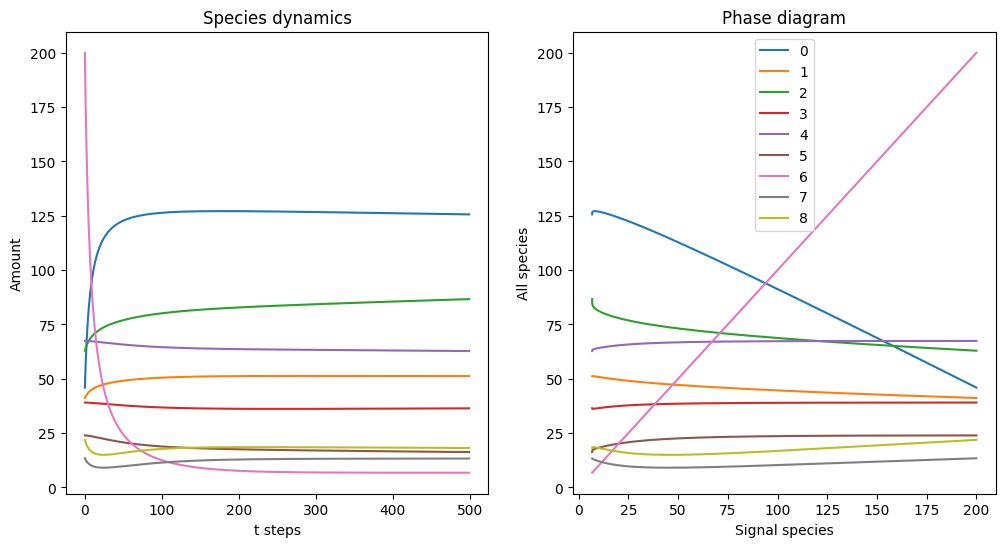

In [46]:
fig = plt.figure(figsize=(12, 6))

ax = plt.subplot(1,2,1)
plt.plot(data_sig.T)
plt.title('Species dynamics')
plt.xlabel('t steps')
plt.ylabel('Amount')

ax = plt.subplot(1,2,2)
plt.plot(np.repeat(data_sig[signal_idx, :][None, :], repeats=data_sig.shape[0], axis=0).T, data_sig[:, :].T)
plt.legend(np.arange(data_sig.shape[0]))
plt.title('Phase diagram')
plt.xlabel('Signal species')
plt.ylabel('All species')



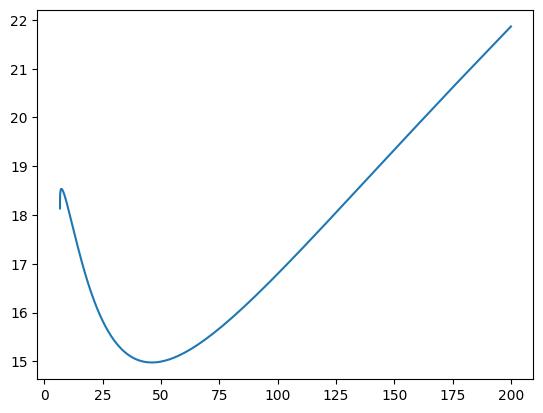

In [36]:
signal_idx = 6
output_idx = 8
plt.plot(data_sig[signal_idx, :], data_sig[output_idx, :])

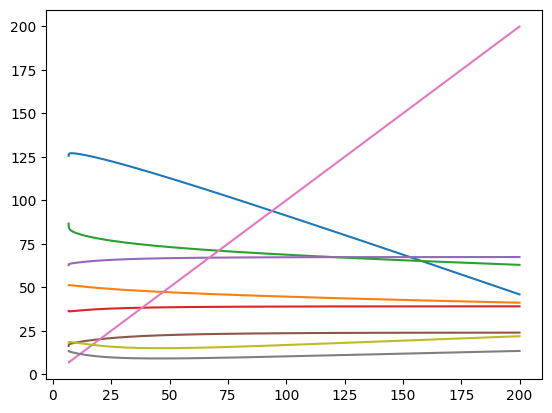

In [42]:
plt.plot(np.repeat(data_sig[signal_idx, :][None, :], repeats=data_sig.shape[0], axis=0).T, data_sig[:, :].T)


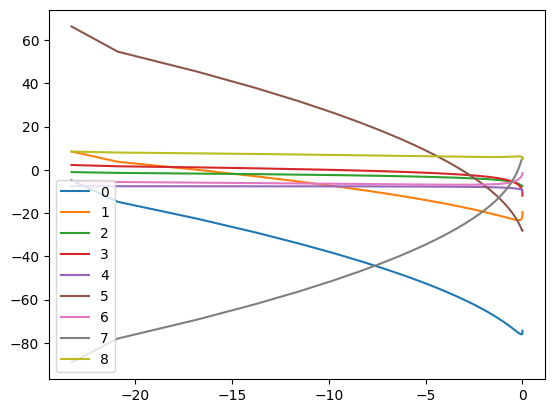

In [39]:
plt.plot(np.repeat(np.gradient(data_sig[signal_idx, :])[None, :], repeats=data_sig.shape[0], axis=0).T, 
         np.gradient(data_sig[:, :])[0].T)
plt.legend(np.arange(data_sig.shape[0]))

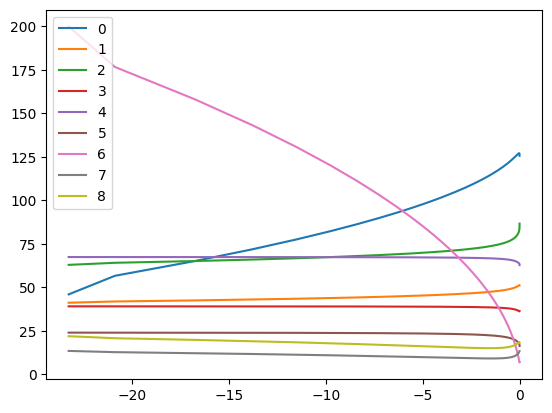

In [40]:
plt.plot(np.repeat(np.gradient(data_sig[signal_idx, :])[None, :], repeats=data_sig.shape[0], axis=0).T, 
         data_sig[:, :].T)
plt.legend(np.arange(data_sig.shape[0]))